Tutorial 2: Parameter Space and Priors
======================================

In the previous tutorial, we used a non-linear search to infer the a lens model that provided a good fit to simulated
imaging data of a strong lens. Now, we will gain deeper intuition of how a non-linear search works.

First, lets develop the concept of a 'parameter space'.

If mathematics, you will have learnt that we can write a simple function as follows:

$f(x) = x^2$

In this function, when we input the parameter $x`$ in to the function $f$, it returns a value $f(x)$. The mappings
between values of $x$ and $f(x)$ define what we can call the parameter space of this function (and if you remember
your math classes, this parameter space is defined by a parabola).

A function can of course have multiple parameters:

$f(x, y, z) = x + y^2 - z^3$

This function has 3 parameters, $x$, $y$ and $z$. The mappings between $x$, $y$ and $z$ and $f(x, y, z)$ define another
parameter space, albeit this parameter space now has 3 dimensions. Nevertheless, just like we could plot a parabole to
visualize the parameter space $f(x) = x^2$, we could visualize this parameter space as 3 dimensional surface.

In the previous tutorial, we discussed how the `AnalysisImaging` class had a `log_likelihood_function` which fitted
the imaging data with a lens model so as to return a log likelihood.

This process can be thought of as us computing a likelihood from a function, just like our functions $f(x)$ above.
However, the log likelihood function is not something that we can write down analytically as an equation and its
behaviour is inherently non-linear. Nevertheless, it is a function, and if we put the same values of lens model
parameters into this function the same value of log likelihood will be returned.

Therefore, we can write our log likelihood function as follows, using terms such as I_{lp}$, $x_{mp}$, $y_{mp}$,
as short-hand notation for the parameters of our light profiles and mass profiles.

$f(I_{lp}, x_{mp},, y_{mp}, ...) = log(likelihood)$

By expressing the likelihood in this way we now have a parameter space! The solutions to this function cannot be written
analytically and it is hihgly complex and non-linear. However, we have already learnt how we use this function to
find solutions which give the highest likelihoods; we use a non-linear search!

To gain further insight, we can inspect the results of the previous tutorial and its 'Probability density functions' or
`PDF' for short. These provide a visual representation of where the non-linear search found the highest likelihood
regions of parameter space for each parameter.

Navigate to the folder `autolens_workspace/output/howtolens/tutorial_1_non_linear_search/images`
and open the `pdf_triangle.png` figure, where:

 - The 1D plots of curved lines show, in one dimension, the values of each parameter that gave the highest likelihood
 solutions.

 - The 2D plots show contours of how different combinations of parameters gave the highest likelihood. When we see
  a curved contour between two parameters, we say that they are 'degenerate', whereby changing both parameters in a
  systematic way leads to models that fit the data equally well. As example degeneracy is between the source's
  intensity $I_{lp}$ and effective radius $R_{lp}$, which makes sense: making the source galaxy brighter and smaller is
  similar to making it fainter and bigger!

So, how does a non-linear search know where to search parameter? A parameter, say, the Einstein Radius, could in
principle take any value between negative and positive infinity. Something must be telling it to only search certain
regions of parameter space with `reasonable` physically plausible values of Einstein radius (between 1.0"-4.0").

These are called the 'priors'. Our priors define where we instruct the non-linear search to search parameter space, and
throughout these tutorials we will use three types of prior:

- UniformPrior: The values of a parameter are randomly drawn between a `lower_limit` and `upper_limit`. For example,
the Einstein radius of an isothermal mass profiles typically assumes a uniform prior between 0.0" and 4.0".

- LogUniformPrior: Like a `UniformPrior` this randomly draws values between a `limit_limit` and `upper_limit`, but the
values are drawn from a distribution with base 10. This is used for the `intensity` of a light profile, as the
luminosity of galaxies follows a log10 distribution.

- GaussianPrior: The values of a parameter are randomly drawn from a Gaussian distribution with a `mean` and width
 `sigma`. For example, the $y$ and $x$ centre values in a light or mass profile typically assume a mean of 0.0" and a
 sigma of 0.3", indicating that we expect the profile centre to be located near the centre of the image.

The default priors of every parameter are provided in the configuration files located at
`autolens_workspace/config/priors/`. Each class of models has a config file (e.g. `light_profiles.json`) and they
follow the following convention:

{
    "SphIsothermal": { <- The name of the `Profile` we are defining the default priors of.
        "einstein_radius": { <- The parameter of the `Profile` we are defining the default priors of.
            "type": "Gaussian", <- The type of prior, in this case a GaussianPrior.
            "lower_limit": 0.0, <- The lower physical limit allowed for values of this parameter.
            "upper_limit": "inf", <- The upper physical limit allowed for values of this parameter.
            "width_modifier": {
                "type": "Relative", <- Ignore these for now.
                "value": 0.05
            },
            "mean": 1.6, <- The `mean` of the GaussianPrior, telling the search where to sample parameter space.
            "sigma": 0.01 <- The `sigma` of the GaussianPrior, telling the search how wide to sample this parameter.
        }
    },
}

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's total mass distribution is a `SphIsothermal`.
 - The source galaxy's `LightProfile` is a `SphExponential`.

In [2]:
dataset_name = "mass_sis__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

__Masking__

we'll create and use a 3.0" `Mask2D` again.

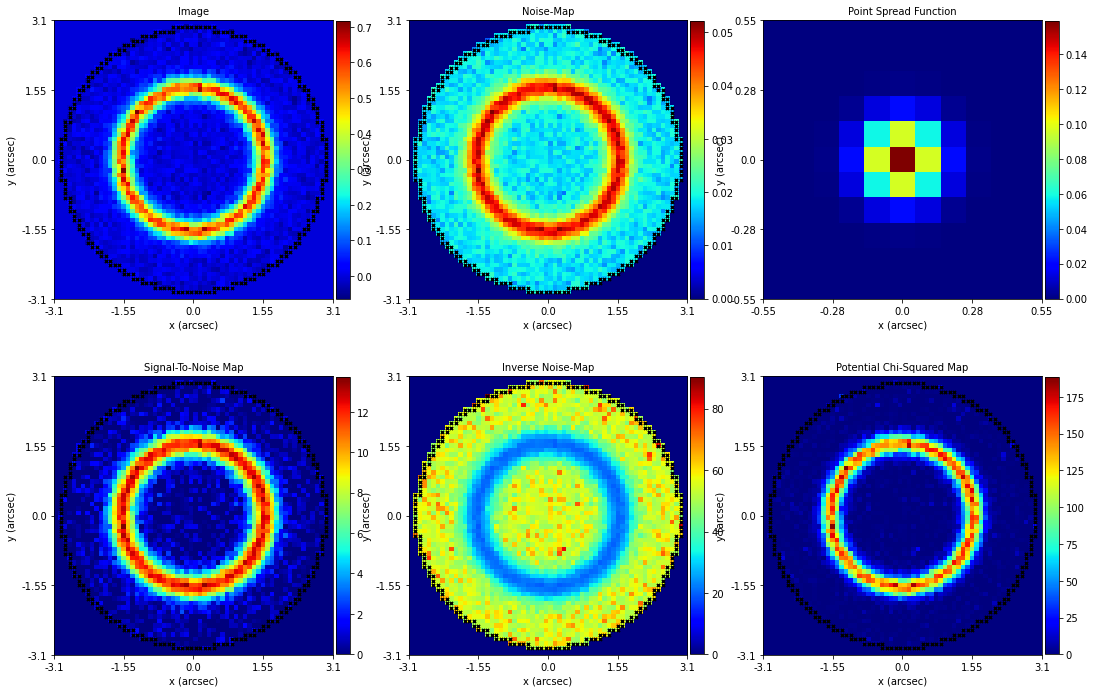

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Prior Customization__

To change the priors on specific parameters, we create our galaxy models and use **PyAutoFit** to set new priors. 

In [4]:
lens = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.SphIsothermal)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.SphExponential)

These two lines change the centre of the lens galaxy's total mass distribution to UniformPriors around the coordinates 
(-0.1", 0.1"). For real lens modeling, this might be done by visually inspecting the centre of emission of the lens 
_Galaxy_`s light.

The word `mass` corresponds to the word we used when setting up the `Model` above.

In [5]:
lens.mass.centre_0 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
lens.mass.centre_1 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)

Lets also change the prior on the lens galaxy's einstein radius to a `GaussianPrior` centred on 1.4". For real lens 
modeling, this might be done by visually estimating the radius the lens's arcs / ring appear.

In [6]:
lens.mass.einstein_radius = af.GaussianPrior(mean=1.4, sigma=0.2)

We can also customize the source galaxy, lets say we believe it is compact and limit its effective radius.

In [7]:
source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=2.0)

We again combine our model components into a `Collection`, which will use the objects with these updated priors.

In [8]:
model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

__Search__

We can now fit this custom model with a search like we did in tutorial 1. 

If you look at the `model.info` file in the output folder of the non-linear search, you'll see that certain priors 
have been updated to the priors we set above.

When setting up dynesty, we include a new input `number_of_cores=2`. The non-linear search can use parallel processing 
to sample multiple lens models at once on your CPU. When `number_of_cores=2` the search will run roughly two times as
fast, for `number_of_cores=3` three times as fast, and so on. The downside is more cores on your CPU will be in-use
which may hurt the general performance of your computer.

You should experiment to figure out the highest value which does not give a noticeable loss in performance of your 
computer. If you know that your processor is a quad-core process you should be able to use `number_of_cores=4`, 
and even higher end processors can potentially use even higher values.

INFO:root:tutorial_2_custom_priors already completed, skipping non-linear search.


Dynesty has begun running - checkout the autolens_workspace/output/howtolens/chapter_2/tutorial_2_parameter_space_and_priors folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


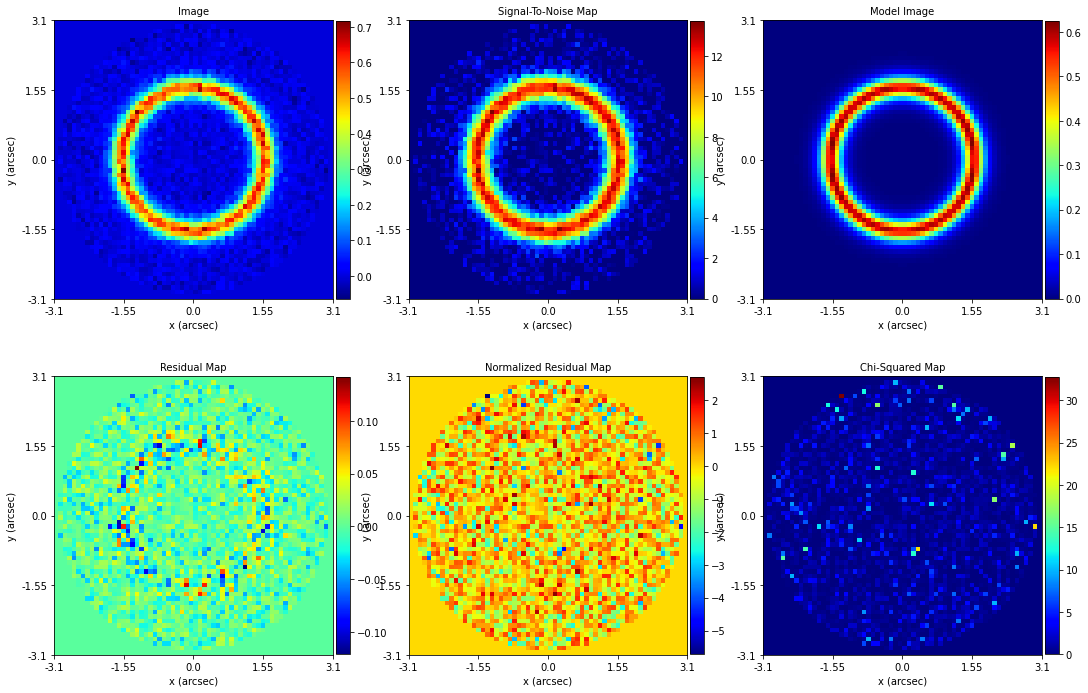

Dynesty has finished run - you may now continue the notebook.


In [9]:
search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_2"),
    name="tutorial_2_custom_priors",
    n_live_points=40,
    number_of_cores=1,
)

analysis = al.AnalysisImaging(dataset=imaging)

result = search.fit(model=model, analysis=analysis)

print(
    "Dynesty has begun running - checkout the autolens_workspace/output/howtolens/chapter_2/tutorial_2_parameter_space_and_priors"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

print("Dynesty has finished run - you may now continue the notebook.")

__Wrap Up__

This tutorial had some pretty difficult concepts to wrap your head around. However, I cannot emphasize 
enough how important it is that you develop an intuition for non-linear searches and the notion of a non-linear 
parameter space. Becoming good at lens modeling is all being able to navigate a complex, degenerate and highly 
non-linear parameter space! Luckily, we're going to keep thinking about this in the next set of tutorials, so if 
you're not feeling too confident yet, you will be soon!

Before continuing to the next tutorial, I want you think about whether anything could go wrong when we search a 
non-linear parameter space. Is it possible that we do not find the highest log likelihood lens model? Why might this be?

Try and list 3 reasons why this might happen. In the next tutorial, we'll learn about just that, failure!